<a href="https://colab.research.google.com/github/giorgosstath16/testrepo/blob/main/Military_aircraft_classify_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [6]:
def residual_block(previous_block):
  #adding 2 convolutional layers (64,3,same padding) w/ relu fx
  #and then add thme to the previous_block output
  x = layers.Conv2D(64,3, activation='relu', padding='same')(previous_block)
  x = layers.Conv2D(64,3,activation='relu', padding='same')(x)
  block_output = layers.add([x, previous_block])
  return block_output

In [8]:
inputs = keras.Input(shape=(32,32,3), name='img')
x = layers.Conv2D(32,3,activation='relu')(inputs)
x = layers.Conv2D(64,3,activation='relu')(x)
block_1_output = layers.MaxPooling2D(2)(x)

#add 2 conv layers (64,3, same pad) w/ relu (x3 times)
block_2_output = residual_block(block_1_output)
block_3_output = residual_block(block_2_output)
block_4_output = residual_block(block_3_output)

x = layers.Conv2D(64,3,activation='relu')(block_4_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(40)(x)

model = keras.Model(inputs, outputs, name='aircraft_resnet')
model.summary()


Model: "aircraft_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 30, 30, 32)   896         ['img[0][0]']                    
                                                                                                  
 conv2d_11 (Conv2D)             (None, 28, 28, 64)   18496       ['conv2d_10[0][0]']              
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 64)  0           ['conv2d_11[0][0]']              
                                                                                    

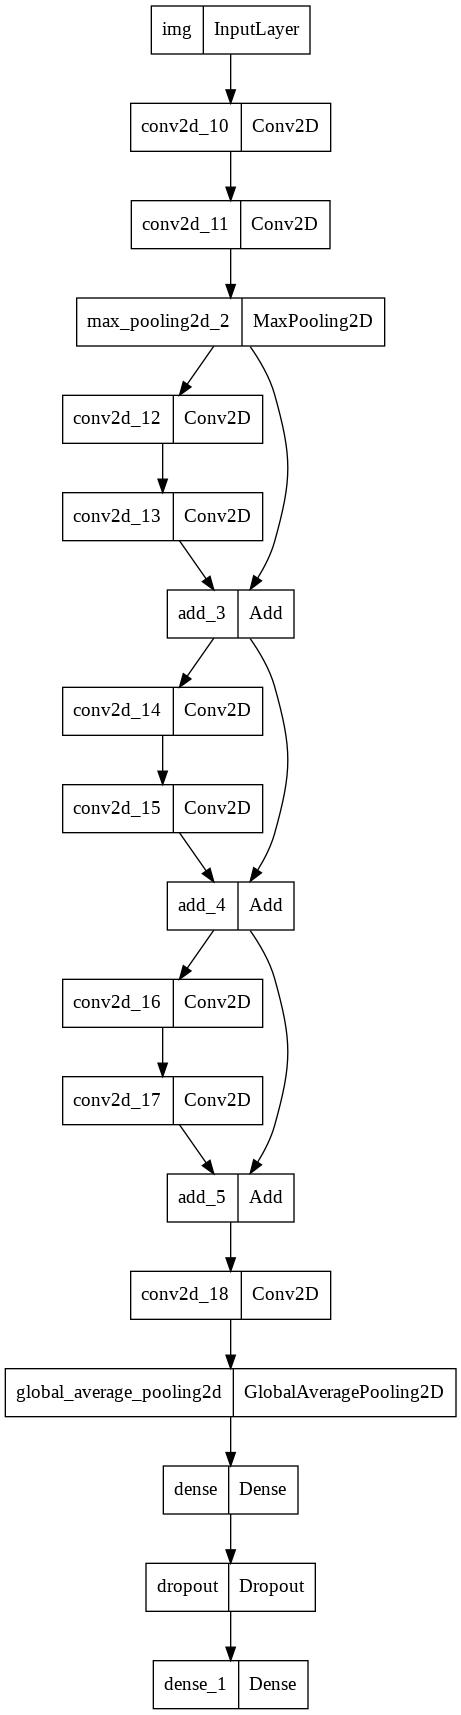

In [9]:
#model vidualization
keras.utils.plot_model(model, 'aircraft_model.png')

In [10]:
#load the aircrafts dataset from kaggle
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

%cd /content/drive/MyDrive/Kaggle

!kaggle datasets download -d a2015003713/militaryaircraftdetectiondataset

%ls

Mounted at /content/drive
/content/drive/MyDrive/Kaggle
100% 6.25G/6.26G [01:13<00:00, 156MB/s]
100% 6.26G/6.26G [01:13<00:00, 91.1MB/s]
autompg/       militaryaircraftdetectiondataset.zip
diabetes/      monkeypox/
dogs-vs-cats/  monkeypox-exploratory-data-analysis-for-beginners.log
iris/          titanic/
kaggle.json


In [11]:
!unzip \militaryaircraftdetectiondataset.zip  -d \militaryaircraftdetectiondataset && rm *.zip  

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: militaryaircraftdetectiondataset/dataset/9a90836057ab9a95536df623df0d1389.csv  
  inflating: militaryaircraftdetectiondataset/dataset/9a90836057ab9a95536df623df0d1389.jpg  
  inflating: militaryaircraftdetectiondataset/dataset/9aaa81880d1d37671d18cd9aca0c8120.csv  
  inflating: militaryaircraftdetectiondataset/dataset/9aaa81880d1d37671d18cd9aca0c8120.jpg  
  inflating: militaryaircraftdetectiondataset/dataset/9aabd19f8037b09cdbdf90940d404249.csv  
  inflating: militaryaircraftdetectiondataset/dataset/9aabd19f8037b09cdbdf90940d404249.jpg  
  inflating: militaryaircraftdetectiondataset/dataset/9aaddcc6bb1c52b07c97855a7a0aa5e0.csv  
  inflating: militaryaircraftdetectiondataset/dataset/9aaddcc6bb1c52b07c97855a7a0aa5e0.jpg  
  inflating: militaryaircraftdetectiondataset/dataset/9aba7d01b95e9bd71a637586d7bae1e5.csv  
  inflating: militaryaircraftdetectiondataset/dataset/9aba7d01b95e9bd71a637586d7bae1e5.jpg  
  inflating: mi

In [15]:
#create A/Cs labels
aircrafts = ["A10","A400M", "AG600","B1","B2","B52", "Be200", "C130","C17","C5", "E2","EF2000",
           "F117","F14","F15","F16","F18","F22","F35","F4",
           "JAS39","MQ9","Mig31","Mirage2000","RQ4","Rafale",
           "SR71","Su57","Tu160","Tu95","U2","US2", "V22","XB70","YF23","J20"]

In [25]:
#create a pd dataframe w/ images and its label in csv
path = "/content/drive/MyDrive/Kaggle/militaryaircraftdetectiondataset/annotated/"
images = glob.glob(path+ '*.jpg')
annot = []
for img in images: annot.append(img.replace('jpg','csv'))
df = pd.DataFrame({'image':images, 'annot':annot})
#preview
df.head()

,image,annot
0,/content/drive/MyDrive/Kaggle/militaryaircraft...,/content/drive/MyDrive/Kaggle/militaryaircraft...
1,/content/drive/MyDrive/Kaggle/militaryaircraft...,/content/drive/MyDrive/Kaggle/militaryaircraft...
2,/content/drive/MyDrive/Kaggle/militaryaircraft...,/content/drive/MyDrive/Kaggle/militaryaircraft...
3,/content/drive/MyDrive/Kaggle/militaryaircraft...,/content/drive/MyDrive/Kaggle/militaryaircraft...
4,/content/drive/MyDrive/Kaggle/militaryaircraft...,/content/drive/MyDrive/Kaggle/militaryaircraft...


In [38]:
#plot some dataset images to preview
def show_samples(n=5):
  img_index = list(np.round((np.random.random(n))*len(df)))
  fig, ax = plt.subplots(1,n,figsize=(10,10))
  i=0
  for idx in img_index:
    img = df.image.values[int(idx)]
    img = Image.open(img)
    ax[i].imshow(img)
    annot = pd.read_csv(df.annot.values[int(idx)])
    for j in range(len(annot)):
      x = annot.x.values[j] #anchor points: x,y
      y = annot.y.values[j]
      h = annot.h.values[j] #height
      w = annot.w.values[j] #width
      rect = patches.Rectangle((x,y,), w, h, linewidth=1, edgecolor='r', forecolor='none')
      #add patch to the axes
      ax[i].add_patch(rect)
    i +=1
  plt.show()
  return None    

FileNotFoundError: ignored

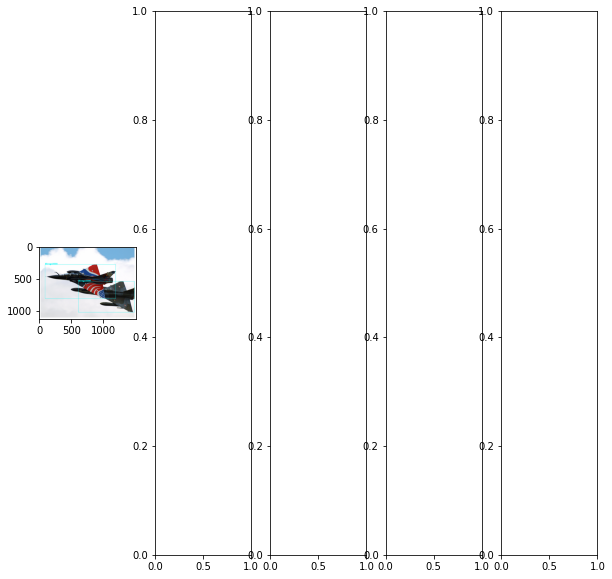

In [40]:
show_samples(n=5)